In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.io import MemoryFile

import fiona
from fiona.transform import transform_geom
from shapely.geometry import shape, mapping

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn

from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [50]:

# Paths to input and output files
# shapefile_path = "./biomass/All_points_July_2024_buffered.shp"
# output_shapefile_path = "./biomass/reprojected_All_points_July_2024_buffered.shp"
shapefile_path = "./biomass/All_points_Sept_2024_buffered.shp"
output_shapefile_path = "./biomass/reprojected_All_points_Sept_2024_buffered.shp"

# Open the shapefile
with fiona.open(shapefile_path, "r") as src:
    # Get the source CRS and target CRS
    src_crs = src.crs
    dst_crs = {"init": "EPSG:4326"}

    # Create a new shapefile with the target CRS
    with fiona.open(output_shapefile_path, "w", driver=src.driver, crs=dst_crs, schema=src.schema) as dst:
        for feature in src:
            # Reproject each geometry
            reprojected_geom = transform_geom(src_crs, dst_crs, feature["geometry"])
            feature["geometry"] = reprojected_geom
            dst.write(feature)

print("Shapefile reprojected successfully!")


C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\1260374631.py:18: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  feature["geometry"] = reprojected_geom


Shapefile reprojected successfully!


In [24]:
# Load the shapefile
shapefile_path = "./biomass/reprojected_All_points_July_2024_buffered.shp"
tiff_a_path = "./biomass/predictions_july_2024_20241221_50px_smallmodel4_filtersavi0.6.tiff"
tiff_b_path = "./biomass/All_Paddock_26_JUL_2024_ortho_bgrent.tiff"
output_csv_path = "./biomass/ndvi_results.csv"

# List to store results
results = []

# Open shapefile and rasters
with fiona.open(shapefile_path) as shp:
    with rasterio.open(tiff_a_path) as tif_a, rasterio.open(tiff_b_path) as tif_b:
        # Read bands for NDVI calculation
        nir = tif_b.read(5)  # NIR band
        red = tif_b.read(3)  # Red band

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red + 1e-6)

        # Create an in-memory raster dataset for NDVI
        profile = tif_b.profile
        profile.update(dtype=rasterio.float32, count=1)

        with MemoryFile() as memfile:
            with memfile.open(**profile) as ndvi_dataset:
                ndvi_dataset.write(ndvi.astype(rasterio.float32), 1)

                # Iterate over each feature in the shapefile
                for feature in shp:
                    print
                    geometry = shape(feature['geometry'])
                    properties = feature['properties']

                    # Extract attributes from the shapefile
                    point = properties.get("Point", None)
                    grass_percent = properties.get("%grass", None)
                    grass_mass = properties.get("grass (kg", None)
                    legume_percent = properties.get("%legume", None)
                    legume_mass = properties.get("Legume (kg", None)
                    total_mass = properties.get("Total mass", None)
                    disk_h = properties.get("Disk Heigh", None)

                    # Mask the single-band TIFF A using the geometry
                    a_masked, _ = mask(tif_a, [geometry], crop=True)
                    a_masked = a_masked.squeeze()

                    # Mask the NDVI using the same geometry
                    ndvi_masked, _ = mask(ndvi_dataset, [geometry], crop=True)
                    ndvi_masked = ndvi_masked.squeeze()

                    # Calculate average NDVI for values 0 and 1 in TIFF A
                    # Calculate average NDVI for values 0 and 1 in TIFF A
                    ndvi_avg_0 = np.nanmean(ndvi_masked[a_masked == 0])
                    ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
                                        # Collect the result
                    results.append({
                        "Point": point,
                        "%grass": grass_percent,
                        "grass(kg)": grass_mass,
                        "%legume":legume_percent,
                        "legume(kg)":legume_mass,
                        "total_mass":total_mass,
                        "disk_height":disk_h,
                        "NDVI_Avg_0_grass": ndvi_avg_0,
                        "NDVI_Avg_1_legume": ndvi_avg_1
                    })

                    print(f"NDVI Average for 0 grass: {ndvi_avg_0}, NDVI Average for 1 legume: {ndvi_avg_1}")

# Convert results to a DataFrame and save to CSV
df_results = pd.DataFrame(results)
df_results.to_csv(output_csv_path, index=False)

print(f"Results saved to {output_csv_path}")

C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\L

NDVI Average for 0 grass: 0.6307414770126343, NDVI Average for 1 legume: nan
NDVI Average for 0 grass: 0.647956132888794, NDVI Average for 1 legume: nan
NDVI Average for 0 grass: 0.6583413481712341, NDVI Average for 1 legume: nan
NDVI Average for 0 grass: 0.553851842880249, NDVI Average for 1 legume: 0.7248561978340149
NDVI Average for 0 grass: 0.655014157295227, NDVI Average for 1 legume: nan
NDVI Average for 0 grass: 0.625671923160553, NDVI Average for 1 legume: nan
NDVI Average for 0 grass: 0.5552185773849487, NDVI Average for 1 legume: 0.8866676688194275
NDVI Average for 0 grass: 0.5725079774856567, NDVI Average for 1 legume: 0.908799946308136
NDVI Average for 0 grass: 0.0, NDVI Average for 1 legume: 0.9021651148796082
NDVI Average for 0 grass: 0.6693402528762817, NDVI Average for 1 legume: 0.919882595539093
NDVI Average for 0 grass: 0.6278589963912964, NDVI Average for 1 legume: nan
NDVI Average for 0 grass: 0.6247033476829529, NDVI Average for 1 legume: nan
NDVI Average for 0 gra

C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])
C:\Users\zhou.tang\AppData\L

NDVI Average for 0 grass: 0.4864349365234375, NDVI Average for 1 legume: 0.8650466203689575
NDVI Average for 0 grass: 0.5225865244865417, NDVI Average for 1 legume: 0.8604301810264587
NDVI Average for 0 grass: 0.0, NDVI Average for 1 legume: 0.8866626620292664
NDVI Average for 0 grass: 0.6555386781692505, NDVI Average for 1 legume: 0.8899553418159485
NDVI Average for 0 grass: 0.6651397943496704, NDVI Average for 1 legume: nan
Results saved to ./biomass/ndvi_results.csv


C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\2746341242.py:54: RuntimeWarning: Mean of empty slice
  ndvi_avg_1 = np.nanmean(ndvi_masked[a_masked == 1])


In [51]:
# Load the shapefile
# shapefile_path = "./biomass/reprojected_All_points_July_2024_buffered.shp"
# tiff_a_path = "./biomass/predictions_july_2024_20241221_50px_smallmodel4_filtersavi0.6.tiff"
# tiff_b_path = "./biomass/All_Paddock_26_JUL_2024_ortho_bgrent.tiff"
# output_csv_path = "./biomass/vegetation_indices_results.csv"

shapefile_path = "./biomass/reprojected_All_points_Sept_2024_buffered.shp"
tiff_a_path = "./biomass/predictions_sep_2024_20241221_50px_smallmodel4_filtersavi0.6.tiff"
tiff_b_path = "./biomass/All_Paddock_22_SEP_2024_ortho_bgrent.tiff"
output_csv_path = "./biomass/vegetation_indices_results_sep2024.csv"

# Function to calculate indices
def calculate_indices(bands):
    # print(";;;;;")
    # print(bands.shape)
    blue = bands[0,:,:]
    green = bands[1,:,:]
    red = bands[2,:,:]
    red_edge = bands[3,:,:]
    nir = bands[4,:,:]
    # print(blue.shape)
    # NDVI
    ndvi = (nir - red) / (nir + red + 1e-6)
    
    # SAVI (L=0.5)
    savi = ((nir - red) / (nir + red + 0.5)) * 1.5
    
    # VARI
    vari = (green - red) / (green + red - blue)
    
    # ExG
    exg = 2 * green - red - blue
    
    # NDRE
    ndre = (nir - red_edge) / (nir + red_edge)
    
    return {
        "NDVI": ndvi,
        "SAVI": savi,
        "VARI": vari,
        "ExG": exg,
        "NDRE": ndre,
    }

# List to store results
results = []

# Open shapefile and process each shape
with fiona.open(shapefile_path) as shp:
    with rasterio.open(tiff_a_path) as tif_a, rasterio.open(tiff_b_path) as tif_b:
        for feature in shp:
            geometry = shape(feature['geometry'])
            properties = feature['properties']

            # Extract attributes from the shapefile
            point = properties.get("Point", None)
            grass_percent = properties.get("%grass", None)
            grass_mass = properties.get("grass (kg", None)
            legume_percent = properties.get("%legume", None)
            legume_mass = properties.get("Legume (kg", None)
            total_mass = properties.get("Total mass", None)
            disk_h = properties.get("Disk Heigh", None)

            # Mask TIFF A (single band)
            a_masked, _ = mask(tif_a, [geometry], crop=True)
            a_masked = a_masked.squeeze()
            # Count pixels with values 0 and 1
            pixel_count_0 = np.sum(a_masked == 0)
            pixel_count_1 = np.sum(a_masked == 1)

            # Read and mask the required bands from TIFF B
            band_masked, _ = mask(tif_b, [geometry], crop=True)
            bands = band_masked.squeeze()
            # print(bands.shape)
            # print("=======")

            # Calculate vegetation indices
            indices = calculate_indices(bands)
            # print(indices.items())

            # Calculate averages for values 0 and 1 in TIFF A
            avg_indices = {}
            for key, array in indices.items():
                print(key)
                print(array.shape)
                print(a_masked.shape)
                avg_indices[f"{key}_Avg_0"] = np.nanmean(array[a_masked == 0])
                avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])

            # Collect the result
            result = {
                "Point": point,
                "%grass": grass_percent,
                "grass(kg)": grass_mass,
                "%legume":legume_percent,
                "legume(kg)":legume_mass,
                "total_mass":total_mass,
                "disk_height":disk_h,
                "Pixel_Count_0": pixel_count_0,
                "Pixel_Count_1": pixel_count_1,
                **avg_indices,
            }
            results.append(result)

# Convert results to a DataFrame and save to CSV
df_results = pd.DataFrame(results)
df_results.fillna(0, inplace=True)
df_results.to_csv(output_csv_path, index=False)

print(f"Optimized results saved to {output_csv_path}")

C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value en

NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)


C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value en

NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(34, 40)
(34, 40)
SAVI
(34, 40)
(34, 40)
VARI
(34, 40)
(34, 40)
ExG
(34, 40)
(34, 40)
NDRE
(34, 40)
(34, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 4

C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value en

NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)


C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _

NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)


C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value en

NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)


C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / 

NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 41)
(35, 41)
SAVI
(35, 41)
(35, 41)
VARI
(35, 41)
(35, 41)
ExG
(35, 41)
(35, 41)
NDRE
(35, 41)
(35, 41)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 40)
NDRE
(35, 40)
(35, 40)
NDVI
(35, 40)
(35, 40)
SAVI
(35, 40)
(35, 40)
VARI
(35, 40)
(35, 40)
ExG
(35, 40)
(35, 4

C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:29: RuntimeWarning: invalid value encountered in divide
  vari = (green - red) / (green + red - blue)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:35: RuntimeWarning: invalid value encountered in divide
  ndre = (nir - red_edge) / (nir + red_edge)
C:\Users\zhou.tang\AppData\Local\Temp\ipykernel_96100\3838412996.py:88: RuntimeWarning: Mean of empty slice
  avg_indices[f"{key}_Avg_1"] = np.nanmean(array[a_masked == 1])
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhou.tang\software\anaconda3\envs\SOC_test\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [81]:
def cross_validation(X, y, fd, randomseed=42, scaler=True, plotname='Random Forest Regression'):
    # Create a KFold object with 5 folds
    kf = KFold(n_splits=fd, shuffle=True, random_state=42)

    # Initialize lists to store train and test indices for each fold
    train_indices_list = []
    test_indices_list = []

    # Split the data into train and test indices for each fold
    for train_indices, test_indices in kf.split(X):
        train_indices_list.append(train_indices)
        test_indices_list.append(test_indices)

    # Convert lists to numpy arrays for convenience (optional)
    # train_indices_list = np.array(train_indices_list)
    # test_indices_list = np.array(test_indices_list)
    
    df_with_fold = X.copy()
    df_with_fold['fold_indx'] = None
    for fold in range(fd):
        fold_id = f"fold_{fold}"
        df_with_fold.iloc[test_indices_list[fold], df_with_fold.columns.get_loc('fold_indx')] = fold_id
    
    df_with_fold.to_csv("../data_with_foldIndex.csv",index=False)
        

    y_true_all = []
    y_pre_all = []
    # Example usage:
    for fold in range(fd):
        print("Fold", fold+1)
        print("Train indices:", len(train_indices_list[fold]))
        print("Test indices:", len(test_indices_list[fold]))
        
        # Step 4: Split the data into training and testing sets
        if scaler:
            X_train = X[train_indices_list[fold]]
            X_test = X[test_indices_list[fold]]
            y_train = y[train_indices_list[fold]]
            y_test = y[test_indices_list[fold]]
        else:
            X_train = X.iloc[train_indices_list[fold]]
            X_test = X.iloc[test_indices_list[fold]]
            y_train = y[train_indices_list[fold]]
            y_test = y[test_indices_list[fold]]

        # Step 5: Train the Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=randomseed)
        rf_model.fit(X_train, y_train)

        # Step 6: Make predictions on the testing set
        y_pred = rf_model.predict(X_test)
        y_true_all.extend(y_test)
        y_pre_all.extend(y_pred)

        # Step 7: Evaluate the model's performance and calculate R-squared
        r_squared = np.corrcoef(y_test, y_pred)[0, 1]**2  # Calculate R-squared value
        print(f"R-squared for fold {fold}:", r_squared)

    r_squared = np.corrcoef(y_true_all, y_pre_all)[0, 1]**2  # Calculate R-squared value
    print(f"R-squared for all:", r_squared)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE for all is {rmse}")
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true_all, y_pre_all, alpha=0.5)
    plt.xlabel('Actual biomass(kg)')
    plt.ylabel('Predicted biomass(kg)')
    plt.title(plotname)
    plt.text(0.1, 0.9, f'R-squared = {r_squared:.3f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.85, f'RMSE = {rmse:.3f}', transform=plt.gca().transAxes)
    plt.grid(True)
    plt.show()
    return y_true_all, y_pre_all



def cross_validation_BayesSearchCV(df, X, y, fd, search_space, randomseed=42, scaler=True, plotname='Random Forest Regression'):
    # Create a KFold object with 5 folds
    kf = KFold(n_splits=fd, shuffle=True, random_state=42)

    # Initialize lists to store train and test indices for each fold
    train_indices_list = []
    test_indices_list = []

    # Split the data into train and test indices for each fold
    for train_indices, test_indices in kf.split(X):
        train_indices_list.append(train_indices)
        test_indices_list.append(test_indices)

    # Convert lists to numpy arrays for convenience (optional)
    # train_indices_list = np.array(train_indices_list)
    # test_indices_list = np.array(test_indices_list)

    y_true_all = []
    y_pre_all = []

    # Example usage:
    for fold in range(fd):
        print("Fold", fold+1)
        print("Train indices:", len(train_indices_list[fold]))
        print("Test indices:", len(test_indices_list[fold]))
        # Step 4: Split the data into training and testing sets
        if scaler:
            X_train = X[train_indices_list[fold]]
            X_test = X[test_indices_list[fold]]
            y_train = y[train_indices_list[fold]]
            y_test = y[test_indices_list[fold]]
        else:
            X_train = X.iloc[train_indices_list[fold]]
            X_test = X.iloc[test_indices_list[fold]]
            y_train = y.iloc[train_indices_list[fold]]
            y_test = y.iloc[test_indices_list[fold]]


        # Step 7: Initialize the RandomForestRegressor
        rf = RandomForestRegressor(random_state=randomseed)

        # Step 8: Set up the BayesSearchCV
        opt = BayesSearchCV(
            estimator=rf,
            search_spaces=search_space,
            n_iter=32,  # Number of parameter settings that are sampled
            cv=5,       # 5-fold cross-validation
            n_jobs=-1,  # Use all available cores
            random_state=randomseed
        )

        # Step 9: Fit the model
        opt.fit(X_train, y_train)

        # Step 10: Print the best parameters and best score
        print("Best Parameters:", opt.best_params_)
        print("Best Score:", opt.best_score_)

        # Step 11: Predict on the test set
        y_pred = opt.predict(X_test)
        df.loc[test_indices_list[fold], 'Predicted'] = y_pred
        y_true_all.extend(y_test)
        y_pre_all.extend(y_pred)

        # Step 7: Evaluate the model's performance and calculate R-squared
        r_squared = np.corrcoef(y_test, y_pred)[0, 1]**2  # Calculate R-squared value
        print(f"R-squared for fold {fold}:", r_squared)

    r_squared = np.corrcoef(y_true_all, y_pre_all)[0, 1]**2  # Calculate R-squared value
    print(f"R-squared for all:", r_squared)

    mse = mean_squared_error(y_true_all, y_pre_all)
    rmse = np.sqrt(mse)
    print(f"RMSE for all is {rmse}")
    df.to_csv(f'data_with_predictions_{plotname}.csv', index=False)
    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true_all, y_pre_all, alpha=0.5)
    plt.xlabel('Actual biomass(kg/ha)')
    plt.ylabel('Predicted biomass(kg/ha)')
    plt.title(plotname)
    plt.text(0.1, 0.9, f'R-squared = {r_squared:.3f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.85, f'RMSE = {rmse:.3f}', transform=plt.gca().transAxes)
    plt.grid(True)
    plt.show()

    return y_true_all, y_pre_all

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [83]:
df1 = pd.read_csv("./biomass/July2024/vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("./biomass/Sep2024/vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)
data



,Point,%grass,grass(kg),%legume,legume(kg),total_mass,disk_height,Pixel_Count_0,Pixel_Count_1,NDVI_Avg_0,NDVI_Avg_1,SAVI_Avg_0,SAVI_Avg_1,VARI_Avg_0,VARI_Avg_1,ExG_Avg_0,ExG_Avg_1,NDRE_Avg_0,NDRE_Avg_1
0,1,100.00,0.0416,0.00,0.0000,0.0416,0.5,1400,0,0.630741,0.000000,0.946089,0.000000,0.544452,0.000000,3155.679286,0.000,0.455081,0.000000
1,2,100.00,0.2542,0.00,0.0000,0.2542,9.0,1400,0,0.647956,0.000000,0.971912,0.000000,0.534347,0.000000,2623.533571,0.000,0.522178,0.000000
2,3,100.00,0.1247,0.00,0.0000,0.1247,4.5,1400,0,0.658341,0.000000,0.987485,0.000000,0.616874,0.000000,2561.072143,0.000,0.525064,0.000000
3,4,100.00,0.0417,0.00,0.0000,0.0417,0.5,1363,72,0.553852,0.724856,0.830754,1.087249,0.445071,0.347125,2807.842993,3155.625,0.382954,0.355455
4,5,100.00,0.1282,0.00,0.0000,0.1282,8.0,1360,0,0.655014,0.000000,0.982493,0.000000,0.570334,0.000000,2753.386765,0.000,0.462342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,44,86.76,0.0891,13.24,0.0136,0.1027,5.0,1435,0,0.567951,0.000000,0.851897,0.000000,0.355714,0.000000,2190.395819,0.000,0.375170,0.000000
92,45,84.39,0.1287,15.61,0.0238,0.1525,7.0,1400,0,0.616136,0.000000,0.924177,0.000000,0.424926,0.000000,2487.042143,0.000,0.423820,0.000000
93,46,86.35,0.0860,13.65,0.0136,0.0996,6.0,1400,0,0.605480,0.000000,0.908191,0.000000,0.413542,0.000000,2472.189286,0.000,0.396093,0.000000
94,47,86.21,0.0863,13.79,0.0138,0.1001,3.5,1400,0,0.595793,0.000000,0.893661,0.000000,0.373238,0.000000,2528.607143,0.000,0.383117,0.000000


In [91]:
target = "total_mass"  
features = [col for col in data.columns if col != target][5:]
data['total_mass'] = data['total_mass'] * 40000
data

,Point,%grass,grass(kg),%legume,legume(kg),total_mass,disk_height,Pixel_Count_0,Pixel_Count_1,NDVI_Avg_0,NDVI_Avg_1,SAVI_Avg_0,SAVI_Avg_1,VARI_Avg_0,VARI_Avg_1,ExG_Avg_0,ExG_Avg_1,NDRE_Avg_0,NDRE_Avg_1
0,1,100.00,0.0416,0.00,0.0000,1664.0,0.5,1400,0,0.630741,0.000000,0.946089,0.000000,0.544452,0.000000,3155.679286,0.000,0.455081,0.000000
1,2,100.00,0.2542,0.00,0.0000,10168.0,9.0,1400,0,0.647956,0.000000,0.971912,0.000000,0.534347,0.000000,2623.533571,0.000,0.522178,0.000000
2,3,100.00,0.1247,0.00,0.0000,4988.0,4.5,1400,0,0.658341,0.000000,0.987485,0.000000,0.616874,0.000000,2561.072143,0.000,0.525064,0.000000
3,4,100.00,0.0417,0.00,0.0000,1668.0,0.5,1363,72,0.553852,0.724856,0.830754,1.087249,0.445071,0.347125,2807.842993,3155.625,0.382954,0.355455
4,5,100.00,0.1282,0.00,0.0000,5128.0,8.0,1360,0,0.655014,0.000000,0.982493,0.000000,0.570334,0.000000,2753.386765,0.000,0.462342,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,44,86.76,0.0891,13.24,0.0136,4108.0,5.0,1435,0,0.567951,0.000000,0.851897,0.000000,0.355714,0.000000,2190.395819,0.000,0.375170,0.000000
92,45,84.39,0.1287,15.61,0.0238,6100.0,7.0,1400,0,0.616136,0.000000,0.924177,0.000000,0.424926,0.000000,2487.042143,0.000,0.423820,0.000000
93,46,86.35,0.0860,13.65,0.0136,3984.0,6.0,1400,0,0.605480,0.000000,0.908191,0.000000,0.413542,0.000000,2472.189286,0.000,0.396093,0.000000
94,47,86.21,0.0863,13.79,0.0138,4004.0,3.5,1400,0,0.595793,0.000000,0.893661,0.000000,0.373238,0.000000,2528.607143,0.000,0.383117,0.000000


Add disk_height with p-value 1.710068655638066e-32
Add ExG_Avg_1 with p-value 0.0014948857381454322
Add VARI_Avg_0 with p-value 0.046191837031357895
Fold 1, Selected Features: ['disk_height', 'ExG_Avg_1', 'VARI_Avg_0']
Add disk_height with p-value 4.762558254970565e-31
Add NDVI_Avg_1 with p-value 0.016110567485881407
Add VARI_Avg_0 with p-value 0.027079393851859066
Fold 2, Selected Features: ['disk_height', 'NDVI_Avg_1', 'VARI_Avg_0']
Add disk_height with p-value 9.656937850535155e-34
Add NDVI_Avg_1 with p-value 0.02361301544419741
Add VARI_Avg_0 with p-value 0.03650379687326811
Fold 3, Selected Features: ['disk_height', 'NDVI_Avg_1', 'VARI_Avg_0']
Add disk_height with p-value 1.168776415220844e-33
Add VARI_Avg_1 with p-value 0.011020617344962787
Fold 4, Selected Features: ['disk_height', 'VARI_Avg_1']
Add disk_height with p-value 2.7162376086430774e-31
Add ExG_Avg_1 with p-value 0.011539753472495093
Add VARI_Avg_0 with p-value 0.009129665374318861
Fold 5, Selected Features: ['disk_hei

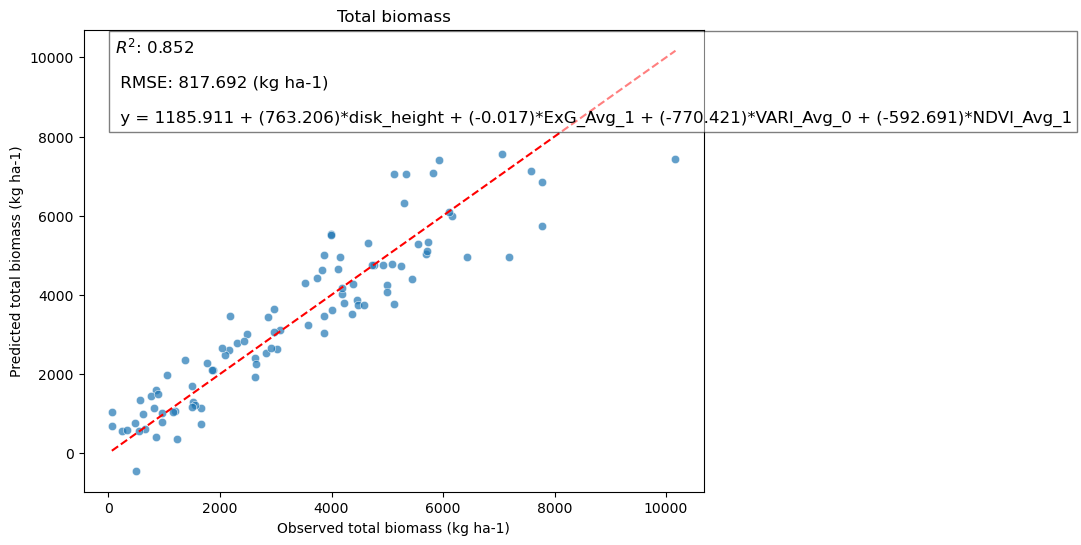

In [114]:
# Load your data
df1 = pd.read_csv("./biomass/July2024/vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("./biomass/Sep2024/vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

target = "total_mass"  # Replace with your target column name
data[target] = data[target] * 40000
features = [col for col in data.columns if col != target][5:]
data = data[data[target] != 0].reset_index(drop=True)
feature_count = 2

# Stepwise Regression Function
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10, verbose=True):
    initial_features = X.columns.tolist()
    best_features = []
    while True:
        changed = False
        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = OLS(y, add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                best_features.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add {best_feature} with p-value {best_pval}")
        
        # Backward step
        model = OLS(y, add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Remove {worst_feature} with p-value {worst_pval}")
        
        if not changed:
            break
    return best_features

# Cross-validation and modeling
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_true = []
all_preds = []
test_indices = [] 

# Store selected features across folds
selected_features_all_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]
    
    # Stepwise regression
    selected_features = stepwise_selection(X_train, y_train, verbose=True)
    selected_features_all_folds.append(selected_features)
    print(f"Fold {fold+1}, Selected Features: {selected_features}")
    
    # Train final model
    model = OLS(y_train, add_constant(X_train[selected_features])).fit()
    predictions = model.predict(add_constant(X_test[selected_features]))
    
    # Collect results
    all_true.extend(y_test)
    all_preds.extend(predictions)
    test_indices.extend(test_idx)

# Evaluate and plot
r2 = r2_score(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))

# Save predictions and ground truth to a CSV
results = pd.DataFrame({
    "index": test_indices,  # Original indices from the dataset
    "Ground Truth": all_true,
    "Prediction": all_preds
})
results.sort_values(by="index", inplace=True)  # Sort by original order
results.to_csv(f"{target}_results.csv", index=False)

# Find the most frequently selected features
feature_counter = Counter([feature for features in selected_features_all_folds for feature in features])
final_features = [feature for feature, count in feature_counter.items() if count >= feature_count]  # Selected in at least 3 folds
print(f"Final Selected Features: {final_features}")

# Fit the final model on the entire dataset
X_final = data[final_features]
y_final = data[target]
final_model = OLS(y_final, add_constant(X_final)).fit()

# Display final model summary
print(final_model.summary())

# Extract the final equation
intercept = final_model.params[0]
coefficients = final_model.params[1:]
equation = f"y = {intercept:.3f} " + " ".join([f"+ ({coef:.3f})*{name}" for name, coef in coefficients.items()])
print("Final Equation:", equation)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_true, y=all_preds, alpha=0.7)
plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], color="red", linestyle="--")
plt.title(f"Total biomass")
plt.xlabel("Observed total biomass (kg ha-1)")
plt.ylabel("Predicted total biomass (kg ha-1)")

# Annotate R2 and RMSE in the plot
plt.text(
    0.05, 0.8,  # Position: Adjust based on your plot's data range
    f"$R^2$: {r2:.3f}\n \n RMSE: {rmse:.3f} (kg ha-1) \n \n {equation}",
    transform=plt.gca().transAxes,  # Place in plot coordinates
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="black")
)

plt.show()



In [117]:
# Load your data
df1 = pd.read_csv("./biomass/July2024/vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("./biomass/Sep2024/vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

target = "grass(kg)"  # Replace with your target column name
data[target] = data[target] * 40000
features = [col for col in data.columns if col != target][5:]
features = ['disk_height','Pixel_Count_0','NDVI_Avg_0','SAVI_Avg_0','VARI_Avg_0','ExG_Avg_0','NDRE_Avg_0']

['disk_height',
 'Pixel_Count_0',
 'Pixel_Count_1',
 'NDVI_Avg_0',
 'NDVI_Avg_1',
 'SAVI_Avg_0',
 'SAVI_Avg_1',
 'VARI_Avg_0',
 'VARI_Avg_1',
 'ExG_Avg_0',
 'ExG_Avg_1',
 'NDRE_Avg_0',
 'NDRE_Avg_1']

Add disk_height with p-value 3.9370845172166624e-28
Add Pixel_Count_0 with p-value 0.000632838931745407
Add VARI_Avg_0 with p-value 0.04384892973093408
Fold 1, Selected Features: ['disk_height', 'Pixel_Count_0', 'VARI_Avg_0']
Add disk_height with p-value 1.7419163424081353e-27
Add Pixel_Count_0 with p-value 0.0005750900932692803
Fold 2, Selected Features: ['disk_height', 'Pixel_Count_0']
Add disk_height with p-value 3.954812474588839e-30
Add Pixel_Count_0 with p-value 0.006117152359683939
Fold 3, Selected Features: ['disk_height', 'Pixel_Count_0']
Add disk_height with p-value 7.709876654076458e-30
Add Pixel_Count_0 with p-value 0.0002511198432821664
Fold 4, Selected Features: ['disk_height', 'Pixel_Count_0']
Add disk_height with p-value 4.4117118043129767e-29
Add Pixel_Count_0 with p-value 0.00040430356140975094
Add VARI_Avg_0 with p-value 0.004375978918511458
Fold 5, Selected Features: ['disk_height', 'Pixel_Count_0', 'VARI_Avg_0']
Final Selected Features: ['disk_height', 'Pixel_Count

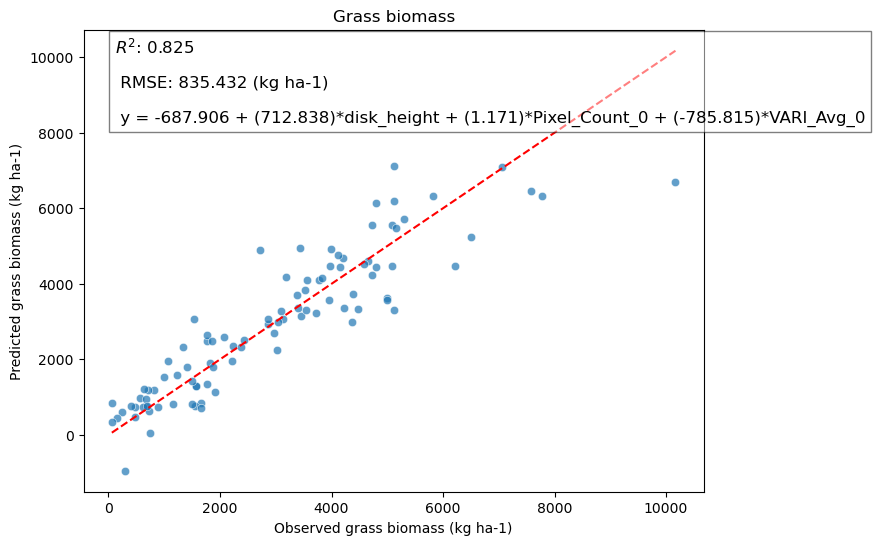

In [118]:
# Load your data
df1 = pd.read_csv("./biomass/July2024/vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("./biomass/Sep2024/vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

target = "grass(kg)"  # Replace with your target column name
data[target] = data[target] * 40000
features = ['disk_height','Pixel_Count_0','NDVI_Avg_0','SAVI_Avg_0','VARI_Avg_0','ExG_Avg_0','NDRE_Avg_0']
data = data[data[target] != 0].reset_index(drop=True)
feature_count = 2

# Stepwise Regression Function
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10, verbose=True):
    initial_features = X.columns.tolist()
    best_features = []
    while True:
        changed = False
        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = OLS(y, add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                best_features.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add {best_feature} with p-value {best_pval}")
        
        # Backward step
        model = OLS(y, add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Remove {worst_feature} with p-value {worst_pval}")
        
        if not changed:
            break
    return best_features

# Cross-validation and modeling
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_true = []
all_preds = []
test_indices = [] 

# Store selected features across folds
selected_features_all_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]
    
    # Stepwise regression
    selected_features = stepwise_selection(X_train, y_train, verbose=True)
    selected_features_all_folds.append(selected_features)
    print(f"Fold {fold+1}, Selected Features: {selected_features}")
    
    # Train final model
    model = OLS(y_train, add_constant(X_train[selected_features])).fit()
    predictions = model.predict(add_constant(X_test[selected_features]))
    
    # Collect results
    all_true.extend(y_test)
    all_preds.extend(predictions)
    test_indices.extend(test_idx)

# Evaluate and plot
r2 = r2_score(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))

# Save predictions and ground truth to a CSV
results = pd.DataFrame({
    "index": test_indices,  # Original indices from the dataset
    "Ground Truth": all_true,
    "Prediction": all_preds
})
results.sort_values(by="index", inplace=True)  # Sort by original order
results.to_csv(f"{target}_results.csv", index=False)

# Find the most frequently selected features
feature_counter = Counter([feature for features in selected_features_all_folds for feature in features])
final_features = [feature for feature, count in feature_counter.items() if count >= feature_count]  # Selected in at least 3 folds
print(f"Final Selected Features: {final_features}")

# Fit the final model on the entire dataset
X_final = data[final_features]
y_final = data[target]
final_model = OLS(y_final, add_constant(X_final)).fit()

# Display final model summary
print(final_model.summary())

# Extract the final equation
intercept = final_model.params[0]
coefficients = final_model.params[1:]
equation = f"y = {intercept:.3f} " + " ".join([f"+ ({coef:.3f})*{name}" for name, coef in coefficients.items()])
print("Final Equation:", equation)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_true, y=all_preds, alpha=0.7)
plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], color="red", linestyle="--")
plt.title(f"Grass biomass")
plt.xlabel("Observed grass biomass (kg ha-1)")
plt.ylabel("Predicted grass biomass (kg ha-1)")

# Annotate R2 and RMSE in the plot
plt.text(
    0.05, 0.8,  # Position: Adjust based on your plot's data range
    f"$R^2$: {r2:.3f}\n \n RMSE: {rmse:.3f} (kg ha-1) \n \n {equation}",
    transform=plt.gca().transAxes,  # Place in plot coordinates
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="black")
)

plt.show()



Add disk_height with p-value 6.382528567743823e-07
Fold 1, Selected Features: ['disk_height']
Add disk_height with p-value 6.06534873204168e-08
Fold 2, Selected Features: ['disk_height']
Add disk_height with p-value 4.461664190168467e-08
Fold 3, Selected Features: ['disk_height']
Add disk_height with p-value 1.7516924865798154e-06
Fold 4, Selected Features: ['disk_height']
Add disk_height with p-value 1.404133604132128e-07
Fold 5, Selected Features: ['disk_height']
Final Selected Features: ['disk_height']
                            OLS Regression Results                            
Dep. Variable:             legume(kg)   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     46.62
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           5.70e-09
Time:                        14:06:39   Log-Likelihood:                -427.33
No. Observation

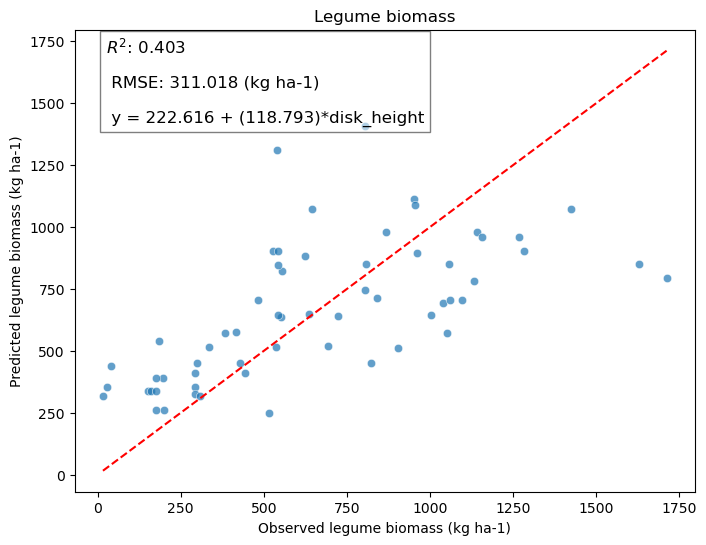

In [119]:
# Load your data
df1 = pd.read_csv("./biomass/July2024/vegetation_indices_results_july2024.csv")
df2 = pd.read_csv("./biomass/Sep2024/vegetation_indices_results_sep2024.csv")
data = pd.concat([df1, df2], ignore_index=True)

target = "legume(kg)"  # Replace with your target column name
data[target] = data[target] * 40000
features = ['disk_height','Pixel_Count_1','NDVI_Avg_1','SAVI_Avg_1','VARI_Avg_1','ExG_Avg_1','NDRE_Avg_1']
data = data[data[target] != 0].reset_index(drop=True)
feature_count = 2

# Stepwise Regression Function
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10, verbose=True):
    initial_features = X.columns.tolist()
    best_features = []
    while True:
        changed = False
        # Forward step
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = OLS(y, add_constant(X[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                best_features.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add {best_feature} with p-value {best_pval}")
        
        # Backward step
        model = OLS(y, add_constant(X[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Remove {worst_feature} with p-value {worst_pval}")
        
        if not changed:
            break
    return best_features

# Cross-validation and modeling
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_true = []
all_preds = []
test_indices = [] 

# Store selected features across folds
selected_features_all_folds = []

for fold, (train_idx, test_idx) in enumerate(kf.split(data)):
    train_data, test_data = data.iloc[train_idx], data.iloc[test_idx]
    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]
    
    # Stepwise regression
    selected_features = stepwise_selection(X_train, y_train, verbose=True)
    selected_features_all_folds.append(selected_features)
    print(f"Fold {fold+1}, Selected Features: {selected_features}")
    
    # Train final model
    model = OLS(y_train, add_constant(X_train[selected_features])).fit()
    predictions = model.predict(add_constant(X_test[selected_features]))
    
    # Collect results
    all_true.extend(y_test)
    all_preds.extend(predictions)
    test_indices.extend(test_idx)

# Evaluate and plot
r2 = r2_score(all_true, all_preds)
rmse = np.sqrt(mean_squared_error(all_true, all_preds))

# Save predictions and ground truth to a CSV
results = pd.DataFrame({
    "index": test_indices,  # Original indices from the dataset
    "Ground Truth": all_true,
    "Prediction": all_preds
})
results.sort_values(by="index", inplace=True)  # Sort by original order
results.to_csv(f"{target}_results.csv", index=False)

# Find the most frequently selected features
feature_counter = Counter([feature for features in selected_features_all_folds for feature in features])
final_features = [feature for feature, count in feature_counter.items() if count >= feature_count]  # Selected in at least 3 folds
print(f"Final Selected Features: {final_features}")

# Fit the final model on the entire dataset
X_final = data[final_features]
y_final = data[target]
final_model = OLS(y_final, add_constant(X_final)).fit()

# Display final model summary
print(final_model.summary())

# Extract the final equation
intercept = final_model.params[0]
coefficients = final_model.params[1:]
equation = f"y = {intercept:.3f} " + " ".join([f"+ ({coef:.3f})*{name}" for name, coef in coefficients.items()])
print("Final Equation:", equation)


plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_true, y=all_preds, alpha=0.7)
plt.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], color="red", linestyle="--")
plt.title(f"Legume biomass")
plt.xlabel("Observed legume biomass (kg ha-1)")
plt.ylabel("Predicted legume biomass (kg ha-1)")

# Annotate R2 and RMSE in the plot
plt.text(
    0.05, 0.8,  # Position: Adjust based on your plot's data range
    f"$R^2$: {r2:.3f}\n \n RMSE: {rmse:.3f} (kg ha-1) \n \n {equation}",
    transform=plt.gca().transAxes,  # Place in plot coordinates
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="black")
)

plt.show()
